## League of Legends Competitive Analysis
    
    by Varun Nadgir

### The Problem

Using the competitive League of Legends match data provided by [Oracle's Elixir](http://oracleselixir.com/match-data/), I will be looking for trends in 'Champion' performance and regional playstyles, among other interesting findings I might come across. The idea is to put myself in the shoes of a professional gaming organization's analyst and try to find ways to give "our" team the edge against an opposing team. This would be particularly useful in international tournaments, when teams that never meet during the regular season challenge each other for the first time.

### The Data

The dataset consists of about 15,000 rows and almost 100 columns. Each game contains 12 rows - 5 for the players on one team, 5 for the other, and 2 for overall team averages. The first few columns are shared values, such as 'gameid', 'league', 'split', 'date' and other meta information regarding the game that was played, while the rest of the columns are in-game values, such as the 'Champion' picked and other performance factors. These data are taken from the 2018 Spring Split from each of the global regions - although we are in the middle of the 2018 Summer Split, I wanted to use a complete dataset.

### Goals

One of the first questions I was interested in exploring was "How do these Champions fare against each other?" This meant the most important variables for this question were the 'champion' and 'result' columns, so I began by shrinking the original dataset down to just containing the information about the region the game was played in, which of the five positions the Champion was played in, and whether or not they won that specific matchup. During this time, I realized that, unfortunately, not all of the 'gameid' values were unique, since some were duplicated across leagues. For now, I chose to separate the champion matchups by region, but one of the next steps will be to combine them. This would help teams when preparing for new competition - after scouting out the Champions they like to play, one could think of potential counters.

My second question *would* require some in-game values - "Does the team with an early lead win, more often than not?" The concept of "snowballing" a lead is a common one in League of Legends, yet some teams still find ways to come back through defensive play or by exploiting a single mistake of the enemy team. This question can also be explored through multiple avenues, such as first blood rate, gold lead, and/or turret/objective lead. 

Finally, I would like to use logistic regression to predict whether the Blue or Red team wins based on the Champions they have selected for themselves. Since I would want to introduce dummy variables for this problem, it would require some reduction. This is because the number of potential dummy variables currently would be, at maximum, **(Number  of  Champions) x (Number of Positions) x (Number of Teams)**, which is around 1400. Instead, by replacing the Champions with their **Primary Archetype** (as labeled by Riot Games themselves), we could reduce this to almost 130. This is dependent on how many unique Champions show up and how strong the initial model is.

### Importing Data

In [46]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
# read in csv
loldf = pd.read_csv('loldata.csv', low_memory=False)

## Champion Head-to-Head Performance

A major part of a strategic or head coach's job when planning for a match is coming up with many potential draft scenarios so that they can be as prepared as possible on game day. This means thinking ahead and wondering what sorts of Champions the enemy will pick for their team. With good preparation, some teams will absolutely win straight from the draft phase due to stronger Champions and better matchups. By studying matchups of the past, a coach can make smarter decisions about which Champions they should prepare for and which Champions they should play.

In [3]:
# subset dataframe, initialize major regions 
df = loldf[['gameid', 'league', 'position', 'team', 'champion', 'result']]
major = ['NALCS', 'EULCS', 'LCK', 'LPL', 'LMS']

#### Collect Champion Statistics

In [4]:
def championstats(position, region=major):
    """Constructs a dataframe of Wins/Losses for all Champion matchups for the given Position.
    Position takes the player position as 'Top', 'Jungle', 'Middle', 'ADC', or 'Support'.
    
    Region can be 'NALCS', 'EULCS', 'LCK', 'LPL', 'LMS', 'TCL', 'NAAc', or 'CBLoL'.
    Region defaults to the 5 Major regions: 'NALCS', 'EULCS', 'LCK', 'LPL', and 'LMS'.
    
    Returns:
        Win/Loss matrix.
    """
    # create the main dataframe by filtering region
    if region == major:
        championdf = df[df['league'].isin(major)]
    else:
        championdf = df[df['league'].isin([region])]
    
    # get list of unique gameIDs from dataframe
    gamelist = championdf['gameid'].unique()
    
    # filter by given position
    positiondf = championdf[championdf['position']==position]
    
    # create groupby object based on 'gameid', each item contains winner and loser of the game
    grouped = positiondf.groupby('gameid')[['champion', 'result']]

    # create a square matrix of 0's with rows/columns equal to number of unique champions picked
    matrix = pd.DataFrame(0, index=positiondf['champion'].unique(), 
                                columns=positiondf['champion'].unique())

    # loop through each unique gameid and add a 1 to each cell location where the ROW defeats the COLUMN
    for i in range(len(gamelist)):
        grouped_champs = grouped.get_group(gamelist[i]).sort_values('result', ascending=False)['champion']
        win_champ = grouped_champs.iloc[0]
        lose_champ = grouped_champs.iloc[1]
        matrix[lose_champ].loc[win_champ] += 1
            
    return matrix

#### Plot Winrates

In [5]:
def plot_winrates(matrix, champion):
    """Takes a dataframe created by championstats() and creates a Win/Loss bar plot for the Champion given.
    
    Returns:
        Bar plot of Wins/Losses.
    """
    # initiate lists for later step
    champlist = list(matrix.index)
    opponents = []
    wins = []
    losses = []
    
    if champion not in champlist:
        print('This Champion was not played in the Region and/or Position you specified.')
        return None
    else:
        # loop through champions list, store wins, losses, and opponent champion
        for opp_champ in sorted(champlist, reverse=True):
            winSide = matrix.at[champion, opp_champ]
            lossSide = matrix.at[opp_champ, champion]
            if ((winSide+lossSide) > 0):
                wins.append(matrix.at[champion, opp_champ])
                losses.append(matrix.at[opp_champ, champion])
                opponents.append(opp_champ)

        # dataframe of winrates
        winrate_df = pd.DataFrame({'greenBars': wins, 'redBars': losses})

        # calculate percentages of wins and losses vs each champion
        totals = [x+y for x,y in zip(winrate_df['greenBars'], winrate_df['redBars'])]
        greenBars = [x/y*100 for x,y in zip(winrate_df['greenBars'], totals)]
        redBars = [x/y*100 for x,y in zip(winrate_df['redBars'], totals)]

        # create horizontal bar plot to show performance vs everyone else
        plt.barh(opponents, greenBars, color='#00ff00')
        plt.barh(opponents, redBars, color='#ff0000', left=greenBars)

        # text labels
        for i in range(len(opponents)):
            if(wins[i]>0):
                plt.text(x=greenBars[i]/2, y=opponents[i], s=wins[i], size=10)
            if(losses[i]>0):
                plt.text(x=100-redBars[i]/2, y=opponents[i], s=losses[i], size=10)

        # label axes and show plot
        plt.title(champion +" Performance")
        plt.xlim(0,100)
        plt.xlabel('Win/Loss Percentage')
        plt.ylabel('Opponent Champion')

        plt.show()

    return None
    

We can now use these functions to explore the various combinations of Positions, Regions, and Champions, as well as catch error cases where the Champion was not picked in a certain Position or Region. This helps make this process scalable for when data comes in from newer competitive seasons, as well as being more suited for an application where we could build buttons and drop-down menus to run these same scripts.

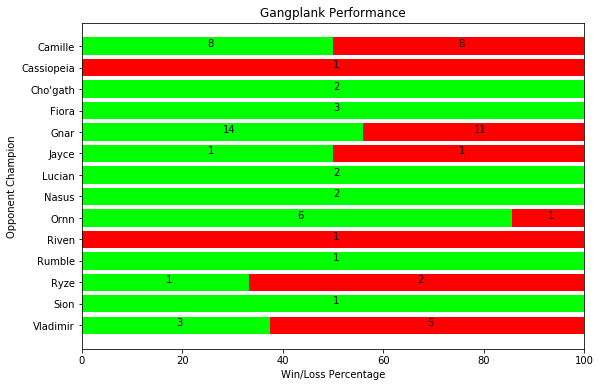

In [7]:
matrix = championstats('Top', 'LCK')
plot_winrates(matrix, 'Gangplank')

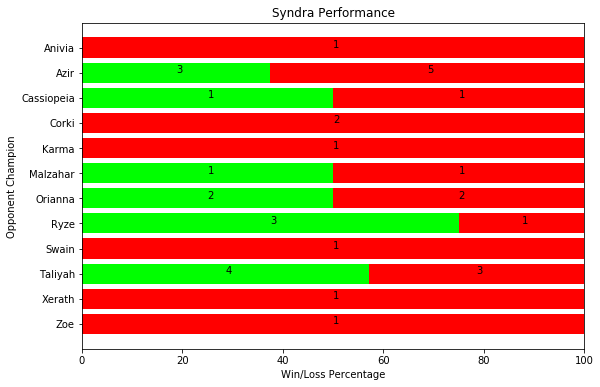

In [8]:
matrix2 = championstats('Middle')
plot_winrates(matrix2, 'Syndra')

In [9]:
plot_winrates(championstats('Top'), 'Ezreal')

This Champion was not played in the Region and/or Position you specified.


## Determining Effectiveness of Early-Game Leads

A prevalent concept in League of Legends, and many other games, is "snowballing" - where smaller leads develop into bigger ones that eventually become too hard to overcome. There are still cases of teams being neck and neck for a majority of a game, until a single decision swings it into one team's favour; as well as cases of a team having the lead for a large portion of a game, only to throw the game in the final moments. I'd like to compare stats of winning teams to stats of losing teams to check for significant differences.

In [10]:
# get rows with just Team data
teams = loldf[loldf['player']=='Team']

# subset to certain columns of in-game stats
teams = teams[['gameid', 'league', 'team', 'result', 
               'teamdragkills', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders',
               'ft', 'firstmidouter', 'firsttothreetowers', 'fbaron', 'wards', 'wpm', 'visionwards', 
               'totalgold', 'goldspent', 'goldat10', 'goldat15', 'xpat10']]

# split dataset into a wins table and losses table
win_teams = teams[teams['result']==1]
lose_teams = teams[teams['result']==0]

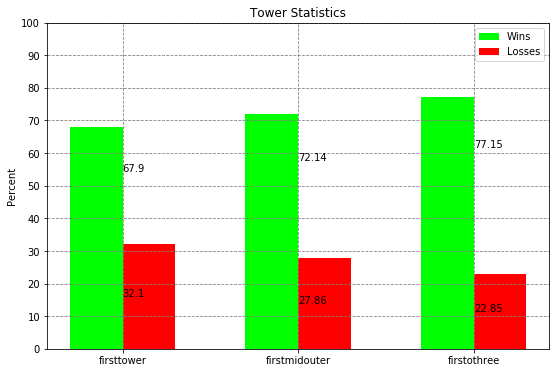

In [11]:
# take a look at tower stats
tower_stats = ['ft', 'firstmidouter', 'firsttothreetowers']

# get means for the three columns
tower_data_w = round(np.mean(win_teams[tower_stats])*100, 2)
tower_data_l = round(np.mean(lose_teams[tower_stats])*100, 2)

# create plot
_, ax = plt.subplots()
plt.bar(tower_stats, tower_data_w, color='#00ff00', width=-0.3, align='edge')
plt.bar(tower_stats, tower_data_l, color='#ff0000', width=0.3, align='edge')

for i in range(len(tower_stats)):
    plt.text(x=tower_stats[i], y=tower_data_w[i]*0.80, s=tower_data_w[i], size=10)
    plt.text(x=tower_stats[i], y=tower_data_l[i]/2, s=tower_data_l[i], size=10)

# label axes and plot elements
plt.title('Tower Statistics')
plt.ylim((0,100))
plt.ylabel('Percent')
plt.legend(('Wins', 'Losses'))
plt.xticks(np.arange(3), ('firsttower', 'firstmidouter', 'firstothree'))
plt.yticks(np.arange(0, 101, step=10))
ax.grid(linestyle='dashed', color='grey')

plt.show()

What we can tell from this is that the winning team almost always has the lead when it comes to taking turrets - winning teams get the first tower almost 70% of the time. In 72% of games, they will take the mid-outer turret first, and in almost 80% of games, the team to destroy three towers first is the team to win. This should support the concept of snowballing, especially because of the increasing chances across this plot. The team who breaks the first tower may not always win, but if the first tower is the middle tower and/or if the first tower leads to breaking two additional towers, the likelihood of winning increases.

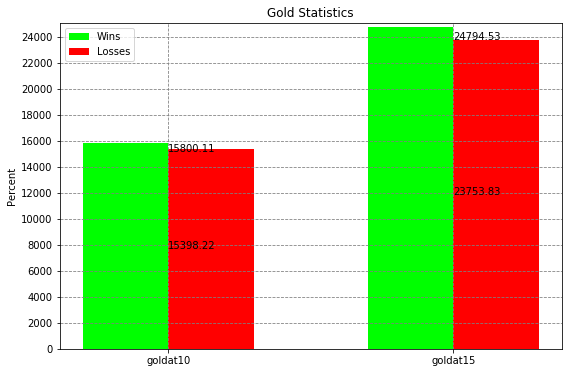

In [12]:
# take a look at gold stats
gold_stats = ['goldat10', 'goldat15']

# get means for the three columns
gold_data_w = round(np.mean(win_teams[gold_stats]), 2)
gold_data_l = round(np.mean(lose_teams[gold_stats]), 2)

# create plot
_, ax = plt.subplots()
plt.bar(gold_stats, gold_data_w, color='#00ff00', width=-0.3, align='edge')
plt.bar(gold_stats, gold_data_l, color='#ff0000', width=0.3, align='edge')

for i in range(len(gold_stats)):
    plt.text(x=gold_stats[i], y=gold_data_w[i]*0.96, s=gold_data_w[i], size=10)
    plt.text(x=gold_stats[i], y=gold_data_l[i]/2, s=gold_data_l[i], size=10)

# label axes and plot elements
plt.title('Gold Statistics')
plt.ylim(0,25100)
plt.ylabel('Percent')
plt.legend(('Wins', 'Losses'))
plt.xticks(np.arange(2), ('goldat10', 'goldat15'))
plt.yticks(np.arange(0, 25001, step=2000))
ax.grid(linestyle='dashed', color='grey')

plt.show()

Another way teams will snowball is by completing a full Item well before their opponent (also called a *Powerspike*) At first glance, this does not seem to suggest much difference. At 10 minutes, the winning team is generally ahead by around 400 gold, which does not translate to any major Item discrepancies, maybe an item component here or there or the team secured the first tower. Then at 15 minutes, winning teams usually grow that lead to 1,000 gold, which at this point could mean that they have taken more towers, or one player is significantly ahead of the rest. To me, this could mean a couple things - either games were very close and the winners played slow, calculated games to victory, or games were blown open through things like dragon leads or fights past the 15 minute mark. We could test this at some point by gathering data from other seasons.

## Win Prediction

As mentioned earlier, good preparation and a strong draft can sometimes outright win you the game. In the event that the teams are considered close, one might wonder who has the edge. For this, we can use logistic regression to predict if Blue team or Red team will win based on the champions picked. We may end up having to reduce the dimenions, since creating dummy variables using all of the possible champions in all possible roles for both teams will end up having over 1,000 columns. Instead, we could replace the Champions with their **Primary Archetype** instead, meaning whether they are a an assassin, a mage, a damage-dealer, etc. By applying this reduction, we can judge team compositions more by their structure.

After a few initial tests, it turns out there are some gameIDs repeated across some regions. Since this prevents us from properly applying groupby and other methods, I defined a function to help deal with those (and potentially even for future datasets of later seasons).

In [13]:
# some duplicate gameIDs have been found
loldf.groupby('gameid')['gameid'].count().sort_values(ascending=False).head(10)

gameid
1002490071                               24
570141                                   24
560575                                   24
550433                                   24
560329                                   24
550268                                   24
651272                                   12
2018-1103Suning GamingInvictus Gaming    12
2018-1102Vici GamingBilibili Gaming      12
2018-1103Bilibili GamingEdward Gaming    12
Name: gameid, dtype: int64

In [14]:
# isolate the duplicates so that we can clean their gameIDs
gameid_dups = ['550268','560329','550433','560575','570141','1002490071']

In [15]:
def clean_duplicates(df, dups):
    """Takes a dataframe of League of Legends games and a list of duplicate gameIDs in order to rename the IDs in a way
    that all are unique.
    
    Returns:
        Cleaned version of original dataframe.
    """
    # subset those rows, and reset index for easier data manipulation
    duplicate_rows = df[df['gameid'].isin(dups)]
    duplicate_rows = duplicate_rows.reset_index()
    
    # mute warning
    pd.set_option('mode.chained_assignment', None)

    # change each repeated gameID to now include the league as a suffix
    for i in range(len(duplicate_rows)):
        duplicate_rows.iat[i, 1] = str(duplicate_rows.iloc[i]['gameid'] + '-' + duplicate_rows.iloc[i]['league'])
    
    # drop rows with duplicate gameIDs
    df = df.drop(df[df['gameid'].isin(dups)].index)
    
    # put back original indices
    duplicate_rows = duplicate_rows.set_index('index', drop=True)
    
    # concatenate dataframes back together
    df = pd.concat([df, duplicate_rows])
    
    return df

In [16]:
# clean loldf to remove duplicate gameIDs
loldf = clean_duplicates(loldf, gameid_dups)

In [17]:
# select columns needed for predictions
match_cols = ['gameid', 'side', 'position', 'champion', 'result']

# subset on those columns, keeping only the rows for players
matchdf = loldf[match_cols]
matchdf = matchdf[matchdf['position']!='Team']

# get the gamelist
gamelist = matchdf['gameid'].unique()

# group the matches by their id
matchgroups = matchdf.groupby(['gameid'])[['side', 'position', 'champion', 'result']]

# initialize empty list
data = []

# loop through each game id and create a list of the champions played
# note that these champions are always in the same order (by side and by position)
for gameid in gamelist:
    data.append(list(matchgroups.get_group((gameid))['champion']))
    
# create list to be used for column names
data_cols = ['Blue Top', 'Blue Jungle', 'Blue Middle', 'Blue ADC', 'Blue Support', 
             'Red Top', 'Red Jungle', 'Red Middle', 'Red ADC', 'Red Support']

# create dataframe of champions played in their respective roles
gamesdf = pd.DataFrame(data, index=gamelist, columns=data_cols)
gamesdf = gamesdf.reset_index()
gamesdf = gamesdf.rename(columns = {'index':'gameid'})
gamesdf.head()

,gameid,Blue Top,Blue Jungle,Blue Middle,Blue ADC,Blue Support,Red Top,Red Jungle,Red Middle,Red ADC,Red Support
0,550246,Ornn,Nidalee,Cassiopeia,Xayah,Tahm Kench,Gnar,Jarvan IV,Ryze,Varus,Braum
1,550247,Gangplank,Rengar,Malzahar,Ezreal,Braum,Vladimir,Lee Sin,Ryze,Sivir,Taric
2,550275,Gangplank,Kha'zix,Ryze,Kog'Maw,Thresh,Gnar,Zac,Azir,Tristana,Shen
3,550331,Gnar,Zac,Azir,Kog'Maw,Tahm Kench,Gangplank,Kha'zix,Veigar,Tristana,Braum
4,550351,Gangplank,Jax,Azir,Varus,Braum,Lucian,Kha'zix,Veigar,Caitlyn,Tahm Kench


In [22]:
# group by id and blue/red side
match_winloss = matchdf.groupby(['gameid', 'side'])['result']

# initialize empty list
winner = []

# Blue side victory appends -1, Red side victory appends 1
for gameid in gamelist:
    if match_winloss.get_group((gameid, 'Blue')).iloc[0] == 1:
        winner.append(-1)
    elif match_winloss.get_group((gameid, 'Red')).iloc[0] == 1:
        winner.append(1)

# create dataframe with only id and winner label
match_results = pd.DataFrame({'gameid':gamelist, 'winner':winner})

gamesdf = gamesdf.merge(match_results)

gamesdf.head()

,gameid,Blue Top,Blue Jungle,Blue Middle,Blue ADC,Blue Support,Red Top,Red Jungle,Red Middle,Red ADC,Red Support,winner
0,550246,Ornn,Nidalee,Cassiopeia,Xayah,Tahm Kench,Gnar,Jarvan IV,Ryze,Varus,Braum,1
1,550247,Gangplank,Rengar,Malzahar,Ezreal,Braum,Vladimir,Lee Sin,Ryze,Sivir,Taric,-1
2,550275,Gangplank,Kha'zix,Ryze,Kog'Maw,Thresh,Gnar,Zac,Azir,Tristana,Shen,1
3,550331,Gnar,Zac,Azir,Kog'Maw,Tahm Kench,Gangplank,Kha'zix,Veigar,Tristana,Braum,-1
4,550351,Gangplank,Jax,Azir,Varus,Braum,Lucian,Kha'zix,Veigar,Caitlyn,Tahm Kench,-1


In [25]:
# transform champions picked into dummy variables
gamesdf_dummies = pd.get_dummies(gamesdf, prefix=data_cols, columns=data_cols)

gamesdf_dummies.head()

,gameid,winner,Blue Top_Akali,Blue Top_Alistar,Blue Top_Ashe,Blue Top_Caitlyn,Blue Top_Camille,Blue Top_Cassiopeia,Blue Top_Cho'gath,Blue Top_Dr. Mundo,...,Red Support_Sion,Red Support_Swain,Red Support_Tahm Kench,Red Support_Taric,Red Support_Thresh,Red Support_Trundle,Red Support_Urgot,Red Support_Vladimir,Red Support_Ziggs,Red Support_Zilean
0,550246,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,550247,-1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,550275,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,550331,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,550351,-1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Logistic Regression using Champions

In [26]:
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(gamesdf_dummies.iloc[:,2:], gamesdf_dummies['winner'], random_state=5)

clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(X, y)

# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtest), ytest))

0.4792332268370607


In [27]:
# list of hyperparameters to try
Cs = [0.0001, 0.001, .01, 1, 10]
param_grid = {'C':Cs}

# create logreg and run grid search over the Cs
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# fit model and print the scores
logreg_cv.fit(X, y)

print(logreg_cv.best_params_)
print(logreg_cv.best_score_)

{'C': 0.01}
0.5426439232409381


In [28]:
# initialize Cs and an empty list for scores
Cs = [0.0001, 0.001, .01, 1, 10]
scores = []

# get an accuracy score for each C, put all in one df
for C in Cs:
    reg = LogisticRegression(C=C)
    reg.fit(X, y)
    y_pred = reg.predict(Xtest)
    scores.append(accuracy_score(y_pred, ytest))

scores_df = pd.DataFrame({'C':Cs, 'Score':scores})

# print scores
scores_df

,C,Score
0,0.0001,0.575080
1,0.0010,0.562300
2,0.0100,0.520767
3,1.0000,0.479233
4,10.0000,0.482428


From the original model up to the models with the C hyperparameter included, we hover between 47% and 57% accuracy on the predictions. Since the gridsearchCV's 'best_params_' method told us that C = 0.1 is the best, we will keep that in mind as we go forward. Although 0.0001 and 0.001 both gave higher accuracy scores, this is most likely due to overfitting and might be misleading.

Next, I will replace the Champions with their archetype instead, and we can see if that makes the modeling any better. This will reduce the dimensionality a bit and will hopefully make the problem less complex for the regression model, thus increasing our accuracy.

In [30]:
champroles = {'Artillery':['Jayce', 'Xerath', 'Vel\'Koz', 'Ziggs'], 
              'Assassin':['Evelynn','Ekko','Akali','Kassadin','Kha\'Zix','Katarina','Talon','Nocturne','Shaco','Fizz','Zed'], 
              'Battlemage':['Taliyah','Ryze','Rumble','Anivia','Aurelion Sol','Cassiopeia','Karthus','Malzahar','Viktor',
                            'Swain','Vladimir'], 
              'Burst':['Lux','Zoe','Lissandra','LeBlanc','Brand','Ahri','Annie','Orianna','Veigar','Twisted Fate','Syndra'], 
              'Catcher':['Zyra','Thresh','Morgana','Pyke','Ivern','Rakan','Blitzcrank','Bard'], 
              'Diver':['Renekton','Rek\'Sai','Rengar','Olaf','Pantheon','Wukong','Warwick','Vi','Xin Zhao','Lee Sin','Kled',
                       'Jarvan IV','Irelia','Hecarim','Camille','Elise','Diana','Skarner'],
              'Enchanter':['Taric','Nami','Sona','Soraka','Karma','Janna','Lulu'],
              'Juggernaut':['Volibear','Trundle','Urgot','Udyr','Mordekaiser','Nasus','Shyvana','Garen','Darius','Dr. Mundo',
                            'Aatrox','Illaoi','Yorick'],
              'Marksman':['Twitch','Varus','Vayne','Miss Fortune','Xayah','Tristana','Lucian','Kindred','Kog\'Maw','Jhin',
                          'Jinx','Kai\'Sa','Kalista','Caitlyn','Ashe','Draven','Corki','Ezreal','Sivir'],
              'Skirmisher':['Riven','Master Yi','Tryndamere','Yasuo','Kayn','Jax','Fiora'],
              'Specialist':['Heimerdinger','Azir','Cho\'Gath','Fiddlesticks','Gnar','Graves','Kennen','Kayle','Quinn','Nidalee',
                            'Singed','Gangplank','Zilean','Teemo'],
              'Vanguard':['Ornn','Sion','Rammus','Sejuani','Nautilus','Alistar','Amumu','Gragas','Leona','Maokai',
                          'Malphite','Zac'],
              'Warden':['Nunu','Poppy','Galio','Braum','Tahm Kench','Shen']
             }

In [32]:
# initialize empty list
data = []

# for each key and value for that key, add the value - key pair to data
for key in champroles:
    for value in champroles[key]:
        data.append([value, key])

# create a dataframe
rolesdf = pd.DataFrame(data, columns=['Champion', 'Role'])
rolesdf.head()

,Champion,Role
0,Jayce,Artillery
1,Xerath,Artillery
2,Vel'Koz,Artillery
3,Ziggs,Artillery
4,Evelynn,Assassin


In [34]:
# initialize empty dict
rolesdict = {}

# construct the "inverse" of the first dict, with champions as the key, role as value (lowercase for lookup purposes)
for i in rolesdf.index:
    rolesdict[rolesdf['Champion'][i].lower()] = rolesdf['Role'][i]

In [35]:
# create a map function 
champ_map = lambda x: rolesdict[str(x).lower()]

In [40]:
# make a copy of gamesdf to be used for roles
gamesdf_roles = gamesdf.copy()

In [41]:
# for each column indicating side and position, replace value using the champ map
for col in gamesdf.columns[1:11]:
    gamesdf_roles.loc[:,col] = gamesdf_roles.loc[:,col].apply(champ_map)
    
gamesdf_roles.head()

,gameid,Blue Top,Blue Jungle,Blue Middle,Blue ADC,Blue Support,Red Top,Red Jungle,Red Middle,Red ADC,Red Support,winner
0,550246,Vanguard,Specialist,Battlemage,Marksman,Warden,Specialist,Diver,Battlemage,Marksman,Warden,1
1,550247,Specialist,Diver,Battlemage,Marksman,Warden,Battlemage,Diver,Battlemage,Marksman,Enchanter,-1
2,550275,Specialist,Assassin,Battlemage,Marksman,Catcher,Specialist,Vanguard,Specialist,Marksman,Warden,1
3,550331,Specialist,Vanguard,Specialist,Marksman,Warden,Specialist,Assassin,Burst,Marksman,Warden,-1
4,550351,Specialist,Skirmisher,Specialist,Marksman,Warden,Marksman,Assassin,Burst,Marksman,Warden,-1


In [42]:
# transform roles picked into dummy variables
gamesdf_roles_dummies = pd.get_dummies(gamesdf_roles, prefix=data_cols, columns=data_cols)

gamesdf_roles_dummies.head()

,gameid,winner,Blue Top_Artillery,Blue Top_Assassin,Blue Top_Battlemage,Blue Top_Diver,Blue Top_Enchanter,Blue Top_Juggernaut,Blue Top_Marksman,Blue Top_Skirmisher,...,Red Support_Battlemage,Red Support_Burst,Red Support_Catcher,Red Support_Diver,Red Support_Enchanter,Red Support_Juggernaut,Red Support_Skirmisher,Red Support_Specialist,Red Support_Vanguard,Red Support_Warden
0,550246,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,550247,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,550275,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,550331,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,550351,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
# Split the data into a training and test set.
X, Xtest, y, ytest = train_test_split(gamesdf_roles_dummies.iloc[:,2:], gamesdf_roles_dummies['winner'], random_state=5)

clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(X, y)

# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtest), ytest))

0.5015974440894568


In [44]:
# list of hyperparameters to try
Cs = [0.0001, 0.001, .01, 1, 10]
param_grid = {'C':Cs}

# create logreg and run grid search over the Cs
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# fit model and print the scores
logreg_cv.fit(X, y)

print(logreg_cv.best_params_)
print(logreg_cv.best_score_)

{'C': 0.01}
0.5298507462686567


In [45]:
# initialize Cs and an empty list for scores
Cs = [0.0001, 0.001, .01, 1, 10]
scores = []

# get an accuracy score for each C, put all in one df
for C in Cs:
    reg = LogisticRegression(C=C)
    reg.fit(X, y)
    y_pred = reg.predict(Xtest)
    scores.append(accuracy_score(y_pred, ytest))

scores_df = pd.DataFrame({'C':Cs, 'Score':scores})

# print scores
scores_df

,C,Score
0,0.0001,0.568690
1,0.0010,0.559105
2,0.0100,0.533546
3,1.0000,0.501597
4,10.0000,0.501597


By changing to roles instead of Champions, the basic logistic regression is marginally better. Whether or not the entire model is better is hard to say, though the scores for the hyperparameters are closer than for the models using Champions. This may suggest less overfitting occurring. Either way, both models could likely be improved by introducing other metrics, such as the pick order or the ban order (since that gives us a sense of more or less importance attached to the pick/ban). Unfortunately, the dataset does not tell us the order in which Champions were picked or banned, so this would need to be done manually another time.

## Conclusion

Using these data, an analyst for an esports team would have a lot of tools at their disposal for better planning and preparation of counter-strategies. Since we can find out which Champions perform best against others, and which objectives on the map generally yield more wins, our team can feel confident going into a match. In a game like League of Legends, small advantages can go a long way, and for important matches, the pressure is on even before the players load into the game.

If you have any questions on how I performed this analysis, or suggestions on ways I can improve, feel free to [email me](mailto:vanadgir@gmail.com). Thanks again to OraclesElixir and Tim Sevenhuysen for collecting and providing this data, and thank you for reading.